In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())

gender                0
age                   0
height                0
weight                0
bmi                   0
family_hist_cnt       0
chronic_meds_cnt      0
procedure_category    0
antibiotics           0
CM_AIDS               0
CM_ANEMDEF            0
CM_ARTH               0
CM_CHF                0
CM_DEPRESS            0
CM_DM                 0
CM_DMCX               0
CM_HTN_C              0
CM_HYPOTHY            0
CM_LIVER              0
CM_OBESE              0
CM_PSYCH              0
CM_SMOKE              0
CM_APNEA              0
CM_CHOLSTRL           0
CM_OSTARTH            0
CM_HPLD               0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 

In [90]:
#Add intra-operative columns
intra_op_cols = ['cvp', 'cvp_a_line', 'cvp_catheter', 'cvp_dvt_pumps','stapling', 'peritoneal_defects', 'bloodloss', 'bloodloss_amt', 'sheath_closure', 'sheath_closure_option', 'TheaterTotalTime', 'SurgeryTotalTime', 'wound_closure', 'post_op', 'regional_block', 'approach', 'drain','common_channel_length', 'billiary_limb_length','allimentary_limb_length','total_bowel_length', 'cholecystectomy_repair', 'incisional_hernia_repair','hiatus_hernia_repair']
intra_op_data = df[intra_op_cols].copy()

MISSING VALUES ANALYSIS
Columns with missing values: 4/24
Total completeness: 94.9%

Top missing columns:
                    Missing_Count  Missing_Percentage
bloodloss_amt                 189           54.941860
regional_block                156           45.348837
peritoneal_defects             64           18.604651
approach                       14            4.069767


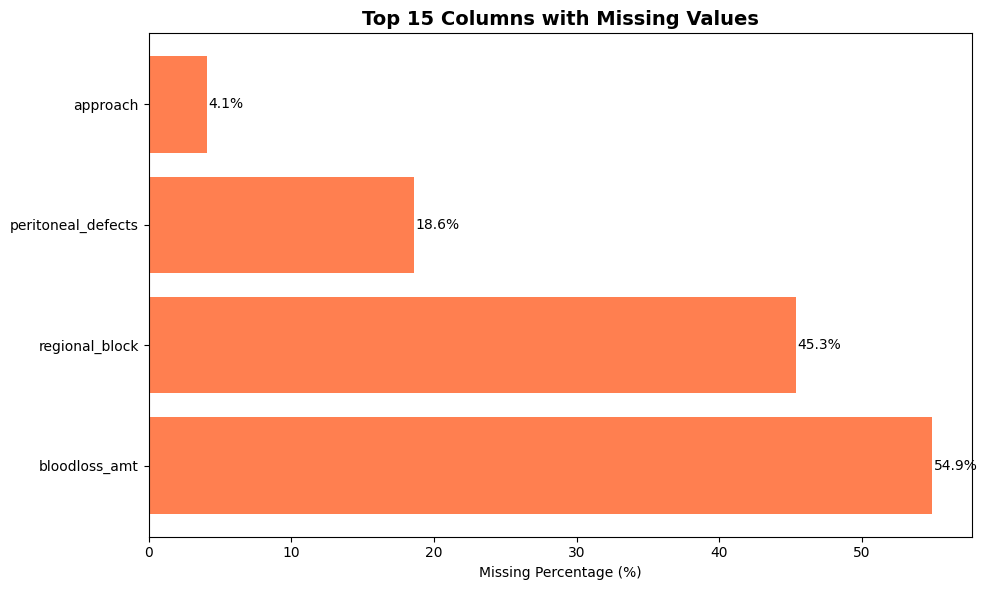

In [91]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': intra_op_data.isnull().sum(),
    'Missing_Percentage': (intra_op_data.isnull().sum() / len(intra_op_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{intra_op_data.shape[1]}")
print(f"Total completeness: {(1 - intra_op_data.isnull().sum().sum()/(intra_op_data.shape[0]*intra_op_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

In [92]:
intra_op_data['bloodloss_amt'] = intra_op_data['bloodloss_amt'].fillna(0)
intra_op_data['approach'] = intra_op_data['approach'].fillna('Open')

In [93]:
intra_op_data.head(300)

,cvp,cvp_a_line,cvp_catheter,cvp_dvt_pumps,stapling,peritoneal_defects,bloodloss,bloodloss_amt,sheath_closure,sheath_closure_option,...,regional_block,approach,drain,common_channel_length,billiary_limb_length,allimentary_limb_length,total_bowel_length,cholecystectomy_repair,incisional_hernia_repair,hiatus_hernia_repair
0,0,0,0,1,Covidien,Prolene,1,100.0,0,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,0
1,0,0,0,0,Echelon,Prolene,0,0.0,0,PDS,...,TAPP,Laproscopic,0,0,0,0,0,1,0,0
2,0,0,0,1,Panther,Prolene,0,0.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
3,0,0,0,0,Panther,NaN,0,0.0,0,PDS,...,NaN,Laproscopic,0,0,0,0,0,0,0,1
4,0,0,1,1,Panther,Prolene,1,250.0,1,PDS,...,TAPP,Laproscopic,1,300,570,0,870,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,0,0,0,Covidien,Prolene,0,0.0,0,PDS,...,NaN,Open,0,0,200,0,0,0,0,0
296,0,0,0,1,Panther,Prolene,1,100.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,1,0,1
297,0,0,0,1,Covidien,NaN,0,0.0,0,PDS,...,NaN,Laproscopic,0,0,220,0,0,0,0,0
298,0,0,0,1,Covidien,Prolene,0,0.0,1,PDS,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1


In [94]:
core_X_data = core_X_data.join(intra_op_data)
core_X_data

,gender,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,procedure_category,antibiotics,CM_AIDS,...,regional_block,approach,drain,common_channel_length,billiary_limb_length,allimentary_limb_length,total_bowel_length,cholecystectomy_repair,incisional_hernia_repair,hiatus_hernia_repair
0,Female,50,154,146.0,61.56,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,0
1,Female,52,168,96.0,34.00,0,0,Sleeve,Kefsol,0,...,TAPP,Laproscopic,0,0,0,0,0,1,0,0
2,Female,23,163,143.0,53.82,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
3,Female,23,176,120.0,38.74,0,0,Sleeve,Kefsol,0,...,NaN,Laproscopic,0,0,0,0,0,0,0,1
4,Female,57,162,112.0,42.68,0,7,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,570,0,870,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Female,24,173,145.0,48.45,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,320,0,620,0,0,1
340,Female,26,149,73.4,33.06,0,0,Mini gastric bypass (OAGB),Augmentin,0,...,NaN,Laproscopic,0,700,220,0,0,0,0,0
341,Female,24,180,153.0,47.22,0,0,SADI,Kefsol,0,...,TAPP,Laproscopic,1,300,0,0,0,0,0,1
342,Female,25,165,154.0,56.57,0,0,RYGBP,Augmentin,0,...,NaN,Laproscopic,0,0,150,80,0,0,0,0


In [95]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [96]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [97]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = core_X_data.copy()
y = core_Y_data['complication'].values

# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


X_encoded.head()

,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,CM_AIDS,CM_ANEMDEF,CM_ARTH,CM_CHF,...,peritoneal_defects_Stratfix,peritoneal_defects_V-lock,sheath_closure_option_PDS,wound_closure_Monocryl,wound_closure_V lock,wound_closure_Vicryl Rapide,post_op_ICU,post_op_Ward,regional_block_TAPP,approach_Open
0,50,154,146.0,61.56,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
1,52,168,96.0,34.00,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
2,23,163,143.0,53.82,0,0,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False
3,23,176,120.0,38.74,0,0,0,0,0,0,...,False,False,True,False,False,False,False,True,False,False
4,57,162,112.0,42.68,0,7,0,0,0,0,...,False,False,True,True,False,False,False,True,True,False


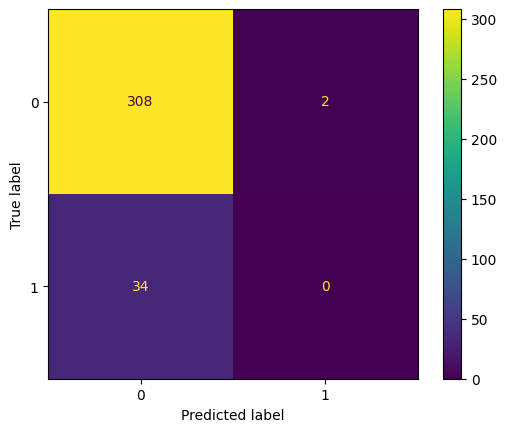

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use this instead of RandomForestRegressor if you're classifying
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Generate predictions
y_pred = cross_val_predict(model, X_encoded, y, cv=5)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 1000),
    'randomforestclassifier__max_depth': [None] + list(range(5, 31, 5)),
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X_encoded, y)

print("Best params:", search.best_params_)
print("Best cross-val accuracy:", search.best_score_)

Best params: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 171}
Best cross-val accuracy: 0.9011935208866155


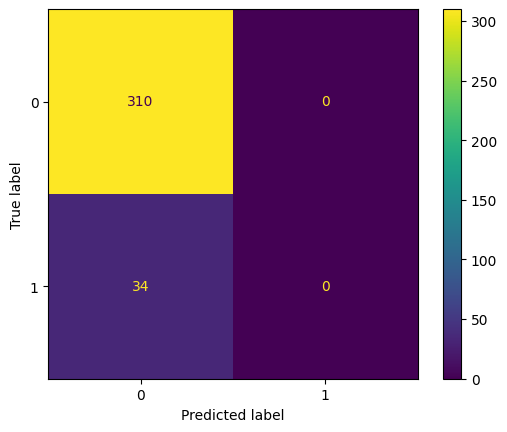

In [103]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        random_state=42
    )
)

y_pred = cross_val_predict(model, X_encoded, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

Best threshold for F1: 0.12
Precision: 0.16, Recall: 0.71, F1: 0.27


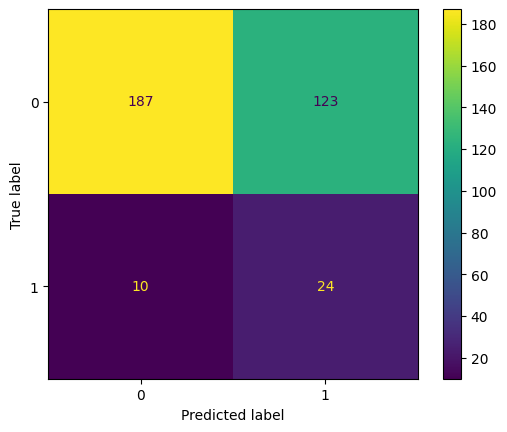

In [104]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get probabilities as before
y_proba = cross_val_predict(model, X_encoded, y, cv=5, method='predict_proba')[:, 1]

# Precision-recall threshold sweep
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Compute F1 score at each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1s[best_idx]:.2f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_opt)
ConfusionMatrixDisplay(cm).plot()
plt.show()


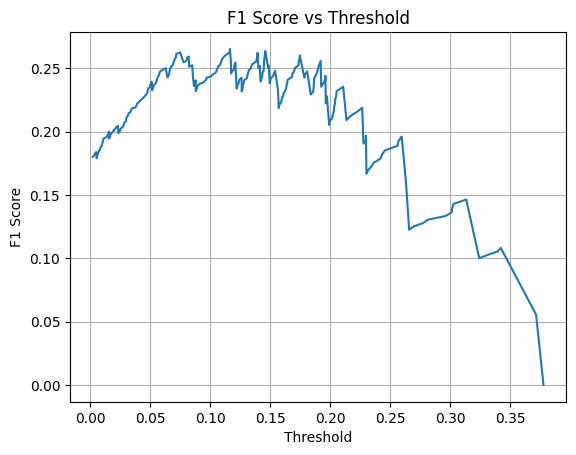

In [105]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1s[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.show()

In [106]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilities from cross-validated model
y_proba = cross_val_predict(model, X_encoded, y, cv=5, method='predict_proba')[:, 1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim so thresholds match
thresholds = np.append(thresholds, 1.0)  # to match length of precisions/recalls

# Print threshold sweep for class 1
for t, p, r in zip(thresholds, precisions, recalls):
    if r >= 0.6 and p >= 0.3:  # adjust these as your desired minimums
        print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {2*p*r/(p+r + 1e-8):.2f}")

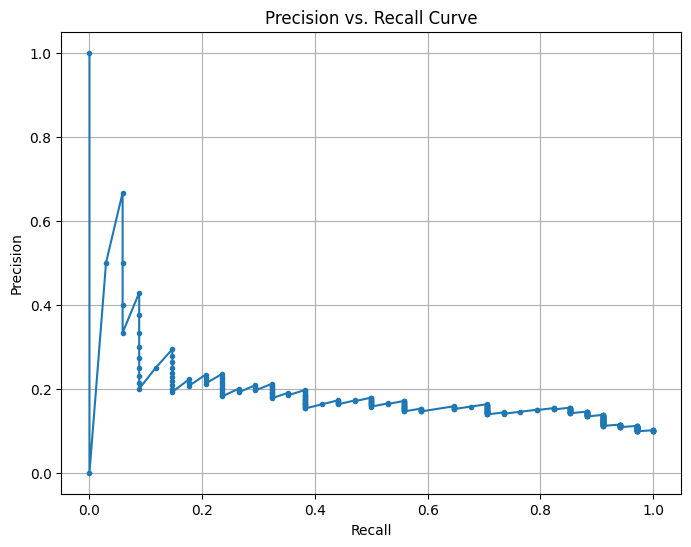

In [108]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities (already done earlier)
y_proba = cross_val_predict(model, X_encoded, y, cv=5, method='predict_proba')[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Curve')
plt.grid(True)
plt.show()


In [112]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
all_thresholds = []
all_f1_scores = []

# Cross-validation loop
for train_idx, test_idx in cv.split(X_encoded, y):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]  # <-- no .iloc here

    # Undersample the majority class in training set only
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Train model
    model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    model.fit(X_resampled, y_resampled)

    # Predict probabilities on test set
    y_proba = model.predict_proba(X_test)[:, 1]

    # Find precision-recall curve for threshold tuning
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Compute F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    all_thresholds.append(best_threshold)
    all_f1_scores.append(best_f1)

    print(f"Fold best threshold: {best_threshold:.3f}, F1: {best_f1:.3f}")

# Overall results
print("\nAverage best threshold:", np.mean(all_thresholds))
print("Average F1 score:", np.mean(all_f1_scores))


Fold best threshold: 0.066, F1: 0.235
Fold best threshold: 0.765, F1: 0.455
Fold best threshold: 0.025, F1: 0.245
Fold best threshold: 0.881, F1: 0.359
Fold best threshold: 0.994, F1: 0.364

Average best threshold: 0.54606078969464
Average F1 score: 0.33146965076326135


In [114]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# 1️⃣ Refit model on full dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)

final_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
final_model.fit(X_resampled, y_resampled)

# 2️⃣ Set your final threshold
final_threshold = np.mean(all_thresholds)
print(f"Deployment threshold: {final_threshold:.3f}")

# 3️⃣ Predict on full dataset (or new unseen dataset if you have it)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]

# Apply threshold to get final predictions
y_pred_final = (y_proba_full >= final_threshold).astype(int)

# 4️⃣ Evaluation metrics

cm = confusion_matrix(y, y_pred_final)
precision = precision_score(y, y_pred_final, zero_division=0)
recall = recall_score(y, y_pred_final, zero_division=0)
f1 = f1_score(y, y_pred_final, zero_division=0)

print("\nConfusion Matrix:")
print(cm)
print("\nPrecision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))

# Optional: full classification report
print("\nClassification Report:")
print(classification_report(y, y_pred_final, zero_division=0))


Deployment threshold: 0.546

Confusion Matrix:
[[197 113]
 [  8  26]]

Precision: 0.187
Recall: 0.765
F1 Score: 0.301

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       310
           1       0.19      0.76      0.30        34

    accuracy                           0.65       344
   macro avg       0.57      0.70      0.53       344
weighted avg       0.88      0.65      0.72       344



In [115]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store thresholds and scores
all_thresholds = []
all_scores = []

# Custom utility function: prioritize recall more heavily
def custom_utility(precision, recall):
    return (3 * precision * recall) / (precision + recall + 1e-10)

for train_idx, test_idx in cv.split(X_encoded, y):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Undersample majority class in train set
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Calculate scale_pos_weight for XGBoost
    pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

    # Train XGBoost model
    model = xgb.XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_resampled, y_resampled)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    # Threshold optimization
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    utility_scores = custom_utility(precision, recall)
    best_idx = np.argmax(utility_scores)
    best_threshold = thresholds[best_idx]
    best_score = utility_scores[best_idx]

    all_thresholds.append(best_threshold)
    all_scores.append(best_score)

    print(f"Fold threshold: {best_threshold:.3f}, Utility Score: {best_score:.3f}")

# Deployment: train on full dataset
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_encoded, y)
pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

final_model = xgb.XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(X_resampled, y_resampled)

final_threshold = np.mean(all_thresholds)
print(f"\nDeployment threshold: {final_threshold:.3f}")

# Evaluate on full data (or external test set if you have one)
y_proba_full = final_model.predict_proba(X_encoded)[:, 1]
y_pred_final = (y_proba_full >= final_threshold).astype(int)

cm = confusion_matrix(y, y_pred_final)
precision = precision_score(y, y_pred_final, zero_division=0)
recall = recall_score(y, y_pred_final, zero_division=0)
f1 = f1_score(y, y_pred_final, zero_division=0)

print("\nConfusion Matrix:")
print(cm)
print("\nPrecision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))
print("\nClassification Report:")
print(classification_report(y, y_pred_final, zero_division=0))


Fold threshold: 0.948, Utility Score: 0.429
Fold threshold: 0.995, Utility Score: 0.900
Fold threshold: 0.425, Utility Score: 0.444
Fold threshold: 0.955, Utility Score: 0.562
Fold threshold: 0.903, Utility Score: 0.750

Deployment threshold: 0.845

Confusion Matrix:
[[249  61]
 [  3  31]]

Precision: 0.337
Recall: 0.912
F1 Score: 0.492

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       310
           1       0.34      0.91      0.49        34

    accuracy                           0.81       344
   macro avg       0.66      0.86      0.69       344
weighted avg       0.92      0.81      0.85       344

